# GAN Convergence


WGAN-GP attempts to learn 2x2 mixture of Gaussians. Plot the kernel density estimate of the generator distribution. Keep track of the KS distance between the generator distribution and real distribution.

Suppose that the real data distribution has probability density function $f:\mathbb{R}^{2} \to [0, 1]$, and generator has pdf $g:\mathbb{R}^{2} \to [0, 1]$. The Kolmogorov-Smirnov distance is:

\begin{equation}
KS(f, g) = \underset{(x, y) \in \mathbb{R}^{2}}{\text{sup}} \, | f(x, y) - g(x, y) |
\end{equation}

If the generator learns the true distribution, $KS(f, g) \to 0$. If the generator memorizes the data, it converges to a strictly positive number.

We estimate the distribution $g$ with a 2D kernel density estimator. Since we know the true DGP, $f$ can be calculated. However, that's a pain, so we just run 10,000 observations from the DGP through a KDE also.

We can visualize the distributions $g$ and $f$ by plotting them on a heat map. We can also see which parts of the distribution the GAN is not exploring by plotting $|f - g|$.

In [1]:
# Packages
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
% matplotlib inline

from scipy.stats import kde

import seaborn as sns
sns.set(font_scale=1.5, rc={'text.usetex' : True})

In [2]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [3]:
# Global Constants
LAMBDA = 0.1
CRITIC_ITER = 5
GENERATOR_ITER = 1000
EPOCHS = GENERATOR_ITER * CRITIC_ITER
BATCH_SIZE = 128
ZDIM = 10
DIM = 512 

EPOCH_CHECK = 500 # How often to calculate KDE of generator

# Dimensions for KDE plots
XMIN, XMAX = -1, 1
YMIN, YMAX = -1, 1
NBINS = 200

## Data Generating Process

We want our DGP to be a 2x2 mixture of bivariate Gaussians. Let's have the modes be at $(-1, -1), (-1, 1), (1, -1), (1, 1)$. Give each Gaussian a variance of $\sigma^{2} = .2$.

I don't know of a convenient way to do this, so let's just make our own class.

In [4]:
# Bivariate Gaussian Mixture Model, 2x2 grid
class BivGMM2:
    def __init__(self):
        self.k = 2*2 
        self.means = np.array([(-1/2, -1/2), (-1/2, 1/2), (1/2, -1/2), (1/2, 1/2)])
        self.covar = np.matrix('.05, 0; 0, .05')
        return None
    
    def sample(self, n):
        draws = np.zeros(shape=(n, 2))
        
        for i in range(n):
            # Pick one of the Gaussians uniformly at random.
            ix = np.random.randint(low=0, high=4)
            
            # Draw from the distribution
            draws[i, :] = np.random.multivariate_normal(mean=self.means[ix], cov=self.covar)
            
        return draws
        
        

## Kernel Density Estimate

In [5]:
class KDE:
    
    def __init__(self, sample):
        
        self.sample = sample
        
        # Density estimate
        self.density_estimate = kde.gaussian_kde(sample.T)
            
        # Meshgrid values for plotting
        self.xi, self.yi = np.mgrid[XMIN:XMAX:NBINS*1j, YMIN:YMAX:NBINS*1j]
        self.z = self.density_estimate(np.vstack([self.xi.flatten(), self.yi.flatten()]))
        
        return None

    def plot(self):
        
        plt.pcolormesh(self.xi, self.yi, self.z.reshape(self.xi.shape), cmap='RdYlBu')
        
        return None

## Distance between two distributions

In [6]:
class KS_distance:
    
    def __init__(self, P1, P2):
        # P1 and P2 must be KDE objects
        
        self.difference = np.abs(P1.z - P2.z)
        
        self.KS = np.max(self.difference)
        
        return None

    def plot(self):
        
        xi, yi = np.mgrid[XMIN:XMAX:NBINS*1j, YMIN:YMAX:NBINS*1j]
        plt.pcolormesh(xi, yi, self.difference.reshape(xi.shape), cmap='RdYlBu')
        
        return None

In [7]:
MM = BivGMM2()
sample = MM.sample(10000)

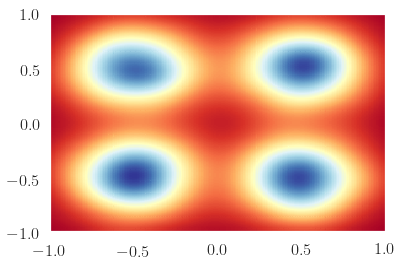

In [8]:
# PLot density
KDE_real = KDE(sample)

KDE_real.plot()

## Dataset object

We need to make a Dataset object so that pytorch can read it

In [9]:
class MixtureData(Dataset):
    def __init__(self, data):
        
        # Data should be an list of n 2-vectors.
        self.data = data
        return None
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

## GAN

Build a GAN whose generator and discriminator are multilayer perceptrons.

### Generator

MLP with a 10x1 vector of noise as input, 2 hidden layers of 128 neurons each, 2x1 output.

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.zDim = ZDIM
        
        self.fc1 = nn.Linear(self.zDim, DIM)
        self.BN1 = nn.BatchNorm1d(DIM)
        
        self.fc2 = nn.Linear(DIM, DIM)
        self.BN2 = nn.BatchNorm1d(DIM)
        
        self.fc3 = nn.Linear(DIM, DIM)
        
        self.fc_out = nn.Linear(DIM, 2)
        
        
        return None

    def forward(self, x):
        x = self.fc1(x)
        x = self.BN1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.BN2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        
        x = self.fc_out(x)
        
        
        return x   

### Critic


In [11]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
                
        self.fc1 = nn.Linear(2, DIM)
        self.fc2 = nn.Linear(DIM, DIM)
        self.fc3 = nn.Linear(DIM, DIM)
        self.fc_out = nn.Linear(DIM, 1)
        return None

    def forward(self, x):
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        
        x = self.fc2(x)
        x = F.leaky_relu(x)
        
        x = self.fc3(x)
        x = F.leaky_relu(x)
        
        x = self.fc_out(x)
                
        return x   

### Gradient Penalty

In [12]:
def gradientPenalty(D, real_data, fake_data, batch_size):
    
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.to(device)
    
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)
    
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    critic_interpolates = D(interpolates)

    gradients = torch.autograd.grad(outputs=critic_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(critic_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

### GAN Object


In [13]:
class GAN:
    def __init__(self, dataloader):
        
        # Instantiate generator and discriminator
        self.batch_size = BATCH_SIZE
        self.zDim = ZDIM
        self.G = Generator().to(device)
        self.D = Critic().to(device)
        
        
        # Optimizer
        self.optimizer_G = torch.optim.Adam(self.G.parameters())
        self.optimizer_D = torch.optim.Adam(self.D.parameters())
        
        # Data loader
        self.dataloader = dataloader
        
        return None
    
    def train(self):
        
        real_label = torch.zeros((self.batch_size, 1)).fill_(1).to(device)
        fake_label = torch.zeros((self.batch_size,1)).fill_(0).to(device)
        
        for i, batch in enumerate(self.dataloader):
            
            #######################
            # Train Discriminator
            self.optimizer_D.zero_grad()
            
            # Realand fake data
            z = torch.randn((self.batch_size, self.zDim), device=device)
            real_data = batch.float().to(device)
            fake_data = self.G(z)
            
            real_loss = self.D(real_data).mean()
            fake_loss = self.D(fake_data).mean()
            
            # Calculate gradient penalty
            grad_penalty = gradientPenalty(self.D, real_data, fake_data, self.batch_size)
            
            critic_loss = fake_loss - real_loss + grad_penalty
            wasserstein_distance = real_loss - fake_loss
            
            critic_loss.backward()
            self.optimizer_D.step()
            
            if i % CRITIC_ITER == 0:
                ########################
                # Train Generator
                self.optimizer_G.zero_grad()
            
                # Fake images
                z = torch.randn((self.batch_size, self.zDim), device=device)
                fake_data = self.G(z)
            
                g_loss = -self.D(fake_data).mean()
            
                g_loss.backward()
                self.optimizer_G.step()
                       
            
        return None

In [14]:
data = MM.sample(2000)

data = MixtureData(data)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

gan = GAN(dataloader)  


In [15]:
# Store KS distance
distance = []
training_step = []


t0 = time.time()
for i in range(EPOCHS):
    gan.train()
    
    if (i % EPOCH_CHECK == 0) or (i == EPOCHS-1):
        # Keep track of time
        print("Completed {0} epochs in {1:.2f} seconds.".format(i, time.time() - t0))
        
        # Keep track of the distance between generated and target distributions.
        # This might be time consuming.
        # Density of generated data
        z = torch.randn((10000, ZDIM), device=device)
        fake_data = gan.G(z).to('cpu').detach().numpy()

        KDE_fake = KDE(fake_data)
        
        # Difference between generated and real
        KDE_diff = KS_distance(KDE_fake, KDE_real)
        
        distance.append(KDE_diff.KS)
        training_step.append(i)



Completed 0 epochs in 0.11 seconds.
Completed 500 epochs in 58.58 seconds.
Completed 1000 epochs in 116.51 seconds.
Completed 1500 epochs in 174.31 seconds.
Completed 2000 epochs in 232.54 seconds.
Completed 2500 epochs in 293.21 seconds.
Completed 3000 epochs in 356.31 seconds.
Completed 3500 epochs in 419.75 seconds.
Completed 4000 epochs in 482.89 seconds.
Completed 4500 epochs in 546.02 seconds.
Completed 4999 epochs in 609.20 seconds.


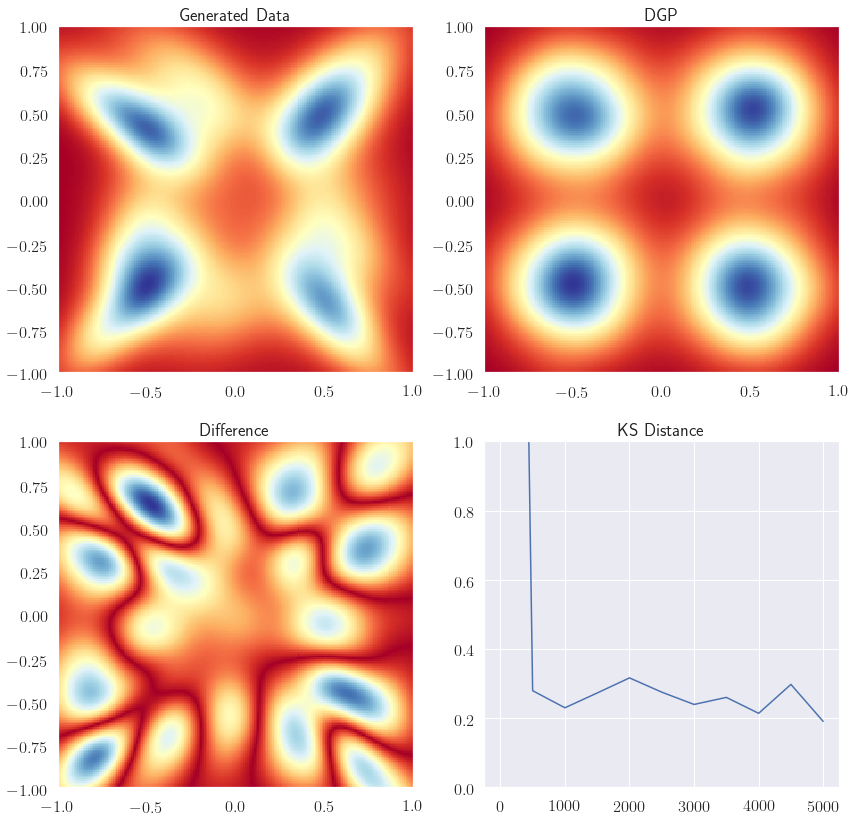

In [16]:
# Plots
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
plt.title("Generated Data")
KDE_fake.plot()

plt.subplot(2, 2, 2)
KDE_real.plot()
plt.title("DGP")

plt.subplot(2, 2, 3)
KDE_diff.plot()
plt.title("Difference")

plt.subplot(2, 2, 4)
plt.plot(training_step, distance)
plt.ylim(0, 1)
plt.title("KS Distance")
plt.show()